In [40]:
# Imports 
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
#from pycocotools.coco import COCO
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.optim as optim
import random
from PIL import Image
from matplotlib import patches
from torchvision.transforms import functional as F
import os
import pandas as pd
import math
import torch.nn.functional as F  
import torch.nn as nn
import shutil  # Used for copying files
from torchvision.transforms import ToTensor
from ultralytics import YOLO
from torchvision.transforms import ToTensor, Resize

# Open the csv file, get all the image name and let the faster RCNN predict what the class it is and stuff
# Create a coco dataset with all the images and bounding box
# Use the images and bounding box to predict the lat lon for different model

In [41]:
# # This is required for visualization of the images with bounding box
# class COCODataset(Dataset):
#     def __init__(self, annotation_file, image_dir, transforms=None):
#         self.coco = COCO(annotation_file)
#         self.image_dir = image_dir
#         self.transforms = transforms
#         self.ids = list(self.coco.imgs.keys())  # List of image IDs

#     def __getitem__(self, index):
#         # Get the image ID and load the associated annotations
#         img_id = self.ids[index]
#         ann_ids = self.coco.getAnnIds(imgIds=img_id)
#         anns = self.coco.loadAnns(ann_ids)
#         image_info = self.coco.loadImgs(img_id)[0]
#         path = image_info['file_name']

#         # Load the image using OpenCV
#         img = cv2.imread(os.path.join(self.image_dir, path))
        
#         if img is None:
#             raise FileNotFoundError(f"Image not found at path: {img_path}")

#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         num_objs = len(anns)
#         boxes = []
#         labels = []
        
#         # Extract the bounding boxes and category labels
#         for i in range(num_objs):
#             xmin = anns[i]['bbox'][0]
#             ymin = anns[i]['bbox'][1]
#             xmax = xmin + anns[i]['bbox'][2]
#             ymax = ymin + anns[i]['bbox'][3]
#             boxes.append([xmin, ymin, xmax, ymax])
#             labels.append(anns[i]['category_id'])

#         # Convert boxes and labels to tensors
#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         if boxes.ndim == 1:
#             boxes = boxes.unsqueeze(0)
#         labels = torch.as_tensor(labels, dtype=torch.int64)
#         image_id = torch.tensor([img_id])
        
#         # Calculate the area of the boxes
#         if boxes.size(0) > 0:  # Check if there are any boxes
#             area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         else:
#             area = torch.tensor([])

#         # Set the crowd flag to 0 (no crowd annotations in this case)
#         iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

#         # Build the target dictionary
#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd

#         # Apply transformations if specified
#         if self.transforms:
#             img = self.transforms(img)

#         return img, target

#     def __len__(self):
#         return len(self.ids)

class COCODataset(Dataset):
    def __init__(self, coco_file, images_dir):
        self.images_dir = images_dir
        self.coco_annotations = self.load_coco_annotations(coco_file)
        self.bounding_boxes, self.image_files = self.process_data(self.coco_annotations)

    def load_coco_annotations(self, file_path):
        with open(file_path, 'r') as f:
            coco_data = json.load(f)
        return coco_data

    def process_data(self, coco_data):
        max_instances_per_class = 2
        num_classes = 9
        data_points = 4
        input_size = num_classes * max_instances_per_class * data_points
        bounding_boxes = []
        image_files = []

        for image_info in coco_data['images']:
            image_id = image_info['id']

            input_vector = [0] * input_size
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    length = 1280.0
                    width = 720.0
                    bbox[0] = bbox[0] / length
                    bbox[1] = bbox[1] / width
                    bbox[2] = bbox[2] / length
                    bbox[3] = bbox[3] / width
                    input_vector[start_index:start_index + 4] = bbox

            bounding_boxes.append(input_vector)
            image_files.append(image_info['file_name'])

        return bounding_boxes, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, image_path

class YOLODataset(Dataset):
    def __init__(self, yolo_file, images_dir):
        self.images_dir = images_dir
        self.yolo_annotations = self.load_yolo_annotations(yolo_file)
        self.bounding_boxes, self.image_files = self.process_data(self.yolo_annotations)

    def load_yolo_annotations(self, file_path):
        with open(file_path, 'r') as f:
            yolo_data = json.load(f)
        return yolo_data

    def process_data(self, yolo_data):
        max_instances_per_class = 2
        num_classes = 9
        data_points = 4
        input_size = num_classes * max_instances_per_class * data_points
        bounding_boxes = []
        image_files = []

        for image_info in yolo_data['images']:
            image_id = image_info['id']

            input_vector = [0] * input_size
            annotations = [ann for ann in yolo_data['annotations'] if ann['image_id'] == image_id]
            for ann in annotations:
                class_id = ann['category_id']
                bbox = ann['bbox']
                instance_index = sum(1 for a in annotations if a['category_id'] == class_id) - 1
                if instance_index < max_instances_per_class:
                    start_index = (class_id * max_instances_per_class + instance_index) * 4
                    length = 1280.0
                    width = 720.0
                    bbox[0] = bbox[0] / length
                    bbox[1] = bbox[1] / width
                    bbox[2] = bbox[2] / length
                    bbox[3] = bbox[3] / width
                    input_vector[start_index:start_index + 4] = bbox

            bounding_boxes.append(input_vector)
            image_files.append(image_info['file_name'])

        return bounding_boxes, image_files

    def __len__(self):
        return len(self.bounding_boxes)

    def __getitem__(self, idx):
        bounding_box = torch.tensor(self.bounding_boxes[idx], dtype=torch.float32)
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        return bounding_box, image_path

In [32]:
# USES THE YOLO MODEL TO CREATE A JSON FILE

import os
import json
from ultralytics import YOLO  # Assuming you are using the Ultralytics YOLOv8 package
import cv2

# Load the trained YOLOv8 model
model = YOLO("yolo.pt")

# Define a function to process images and extract predictions
def process_images(image_dir, output_json):
    images = []
    annotations = []
    image_id = 1
    annotation_id = 1
    
    # Loop through each image in the directory
    for image_file in os.listdir(image_dir):
        if image_file.endswith(".jpg") or image_file.endswith(".png"):  # Check for image files
            image_path = os.path.join(image_dir, image_file)
            img = cv2.imread(image_path)

            # Run YOLOv8 prediction
            results = model(image_path)

            # Add image information
            images.append({
                "id": image_id,
                "file_name": image_file
            })

            # Loop through each prediction for the current image
            for result in results[0].boxes:
                # Extract bounding box, category, and score
                bbox = result.xyxy[0].tolist()  # YOLOv8 gives the bounding box as [x_min, y_min, x_max, y_max]
                category_id = int(result.cls) + 1  # Assuming category IDs start from 1
                score = float(result.conf)  # Confidence score

                # Convert bbox to COCO format (x_min, y_min, width, height)
                bbox = [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]

                # Add annotation information
                annotations.append({
                    "id": annotation_id + 1,
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": bbox,
                    "score": score
                })
                annotation_id += 1

            image_id += 1

    # Prepare final JSON structure
    output_data = {
        "images": images,
        "annotations": annotations
    }

    # Write the output to a JSON file
    with open(output_json, "w") as f:
        json.dump(output_data, f, indent=4)

# Directory containing your images
image_directory = "captured_images_test7"

# Output JSON file
output_file = "yolo_annotations.json"

# Process the images and create JSON file
process_images(image_directory, output_file)



image 1/1 /home/chmalinc/GitHub/project-oval/ML/DeepLearning/DataSetup/captured_images_test7/2024-09-08-16_21_10.jpg: 384x640 1 street-lamp, 2.3ms
Speed: 0.7ms preprocess, 2.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/chmalinc/GitHub/project-oval/ML/DeepLearning/DataSetup/captured_images_test7/2024-09-08-16_35_08.jpg: 384x640 (no detections), 1.9ms
Speed: 0.7ms preprocess, 1.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/chmalinc/GitHub/project-oval/ML/DeepLearning/DataSetup/captured_images_test7/2024-09-08-16_02_20.jpg: 384x640 1 FW, 1 HUNT, 1 street-lamp, 1.9ms
Speed: 0.7ms preprocess, 1.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/chmalinc/GitHub/project-oval/ML/DeepLearning/DataSetup/captured_images_test7/2024-09-08-16_06_19.jpg: 384x640 1 engineering-building, 2 trashcans, 5.1ms
Speed: 0.9ms preprocess, 5.1ms inference, 0.9ms postprocess per image at shape (1,

KeyboardInterrupt: 

# Model (FFNN, LSTM) Architecture for Lat and Lon Prediction

# FFNN Architecture with first 3 digits

In [42]:
class LatLonModelFFNNWith3Digits(nn.Module):
    def __init__(self):
        super(LatLonModelFFNNWith3Digits, self).__init__()
        self.fc1 = nn.Linear(72, 40)
        self.bn1 = nn.BatchNorm1d(40)
        self.fc2 = nn.Linear(40, 2)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# FFNN Architecture without first 3 digits

In [43]:
class LatLonModelFFNNWithOut3Digits(nn.Module):
    def __init__(self):
        super(LatLonModelFFNNWithOut3Digits, self).__init__()
        self.fc1 = nn.Linear(72, 256)
        self.bn1 = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        
        self.fc5 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        return x

# LSTM Architecture with first 3 digits

In [44]:
class LatLonModelLSTMWith3digits(nn.Module):
    def __init__(self):
        super(LatLonModelLSTMWith3digits, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=72, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
        
        # Fully connected layers with consistent sizes
        self.fc1 = nn.Linear(256, 256)  # Keep the output size same as input for skip connection
        self.fc2 = nn.Linear(256, 128)  # Reduce size in the second layer
        self.fc3 = nn.Linear(128, 2)    # Final layer for output

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(256)
        
        # Dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension for LSTM
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Take the output of the last time step
        
        # First fully connected layer with skip connection
        residual = x  # Save input for the skip connection
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x += residual  # Add skip connection
        
        x = self.dropout(x)
        
        # Second fully connected layer (no skip connection here)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# LSTM Architecture without first 3 digits

In [55]:
#LSTM
class LatLonModelLSTMWithout3digits(nn.Module):
    def __init__(self):
        super(LatLonModelLSTMWithout3digits, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=72, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)  # Reduced from 512 to 256
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        
        # Dropout
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension for LSTM
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Take the output of the last time step
        
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

# Get hold of data from CSV file

In [8]:
import pandas as pd

# Function to open the CSV file, correct the image names, and extract swift lat/lon data
def open_csv(filepath):
    """Opens CSV, returns modified filenames and corresponding swift lat/lon."""
    df = pd.read_csv(filepath, encoding='utf-8')  # Ensure correct encoding

    corrected_image = []
    swift_data = []
    
    # Making the correct format and extract swift_lat, swift_lon
    for index, row in df.iterrows():
        image = row["image_name"]
        
        if isinstance(image, str):  # Ensure the value is a string
            corrected_img_name = image.replace(":", "_").strip()  # Replace ":" and remove leading/trailing spaces
            corrected_image.append((corrected_img_name, row["swift_latitude"], row["swift_longitude"]))
        else:
            continue
    
    return corrected_image 

csv_path = "test_7/position_data_logger.csv"
corrected_image = open_csv(csv_path)
print(len(corrected_image))
print(corrected_image[:20])
print(isinstance(corrected_image, list))

FileNotFoundError: [Errno 2] No such file or directory: 'test_7/position_data_logger.csv'

In [14]:
found_image = []
not_found_image = []
folder_path = "test_7/captured_images_test7"
for filename in corrected_image:
    file, lat, lon = filename
    file_path = os.path.join(folder_path, file)
    
    if not os.path.isfile(file_path):
        not_found_image.append(filename)
    else:
        found_image.append(filename)
        
print(len(found_image))
print(found_image[:20])
print(len(not_found_image))

2112
[('2024-09-08-15_22_15.jpg', 35.7711512322439, -78.6739819342967), ('2024-09-08-15_22_17.jpg', 35.7711342470924, -78.6739971917349), ('2024-09-08-15_22_19.jpg', 35.7711140432787, -78.6740133320289), ('2024-09-08-15_22_21.jpg', 35.7710938628983, -78.674033581905), ('2024-09-08-15_22_23.jpg', 35.7710737387602, -78.6740491115901), ('2024-09-08-15_22_25.jpg', 35.7710553816594, -78.6740621245691), ('2024-09-08-15_22_27.jpg', 35.7710342310763, -78.6740784431818), ('2024-09-08-15_22_29.jpg', 35.7710142073795, -78.6740935657712), ('2024-09-08-15_22_31.jpg', 35.7709934078664, -78.6741091332326), ('2024-09-08-15_22_33.jpg', 35.7709738044288, -78.6741257466179), ('2024-09-08-15_22_35.jpg', 35.770952349122, -78.6741423858114), ('2024-09-08-15_22_37.jpg', 35.7709299054234, -78.6741589816041), ('2024-09-08-15_22_39.jpg', 35.7709047461554, -78.6741750122562), ('2024-09-08-15_22_41.jpg', 35.7708848766937, -78.6741895761486), ('2024-09-08-15_22_44.jpg', 35.7708634880776, -78.6742050178157), ('2024

# Creates a COCODataset using Faster RCNN for detecting 9 classes (sign, FW, HUNT, OVAL, engineering-building, security-station, sign, street-lamp, trashcan)

In [15]:
# Load the Faster RCNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one (for 9 classes + background)
num_classes = 9 + 1  # 9 classes + background
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the model state dict (from previously saved model)
model_save_path = "faster_rcnn.pth"
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Categories for COCO format
categories = [
    {"id": 0, "name": "sign"},
    {"id": 1, "name": "FW"},
    {"id": 2, "name": "HUNT"},
    {"id": 3, "name": "OVAL"},
    {"id": 4, "name": "engineering-building"},
    {"id": 5, "name": "security-station"},
    {"id": 6, "name": "sign"},
    {"id": 7, "name": "street-lamp"},
    {"id": 8, "name": "trashcan"}
]

# ['sign', 'FW', 'HUNT', 'Oval', 'engineering-building', 'security-station', 'sign', 'street-lamp', 'trashcan']
def load_image(file_path):
    image = Image.open(file_path).convert("RGB")
    transform = ToTensor()  # Create a ToTensor transformation
    return transform(image).unsqueeze(0)  # Convert image to tensor and add batch dimension

# Function to annotate images in COCO format
def annotate_images_in_folder(found_images, folder_path, output_json_path, threshold=0.5):
    image_id = 1
    annotation_id = 1
    coco_annotations = {
        "images": [],
        "annotations": [],
        "categories": categories
    }
    # print(found_images)
    # Loop through found images, checking if they exist in the folder
    for image_info in found_images:
        filename, swift_latitude, swift_longitude = image_info
        # print(filename)
        file_path = os.path.join(folder_path, filename)
        if not os.path.isfile(file_path):
            # print(f"Image not found: {filename}")
            continue  # Skip if the image is not found

        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load and preprocess the image
            image = load_image(file_path).to(device)

            # Predict using Faster R-CNN
            with torch.no_grad():
                prediction = model(image)

            # Get image dimensions
            image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
            height, width, _ = image_np.shape

            # Append image details to COCO annotations
            coco_annotations["images"].append({
                "id": image_id,
                "file_name": filename,
                "width": int(width),
                "height": int(height),
                "swift_latitude": float(swift_latitude),  # Add swift latitude
                "swift_longitude": float(swift_longitude)  # Add swift longitude
            })

            # Get the predictions
            boxes = prediction[0]['boxes'].cpu().numpy()
            scores = prediction[0]['scores'].cpu().numpy()
            labels = prediction[0]['labels'].cpu().numpy()

            # Create a list of (score, label, box) tuples and sort by score descending
            predictions = sorted(zip(scores, labels, boxes), key=lambda x: x[0], reverse=True)

            # Keep track of the count of predictions per label type (to limit to 2 per class)
            label_counts = {}

            # Add top 2 predictions for each class
            for score, label, box in predictions:
                if score >= threshold:
                    if label not in label_counts:
                        label_counts[label] = 0
                    if label_counts[label] < 2:
                        xmin, ymin, xmax, ymax = box
                        width = xmax - xmin
                        height = ymax - ymin
                        coco_annotations["annotations"].append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": int(label),
                            "bbox": [float(xmin), float(ymin), float(width), float(height)],
                            "score": float(score)
                        })
                        label_counts[label] += 1
                        annotation_id += 1

            image_id += 1

    # Save the annotations to a JSON file
    with open(output_json_path, 'w') as f:
        json.dump(coco_annotations, f, indent=4)

# Example usage:
folder_path = 'test_7/captured_images_test7'  # The folder where the images are stored
output_json_path = 'test_7/RCNN_BBOX_WITH_LAT_LON.json'

# Annotate images and create a COCO-style dataset
annotate_images_in_folder(corrected_image, folder_path, output_json_path)
print("Finished creating COCO-style annotations.")

Finished creating COCO-style annotations.


# Creates a COCODataset using Yolo Model for detecting 9 classes ()

In [1]:
model_path = "best.pt"
yolo_model = YOLO(model_path)
test_image = "test_image1.jpg"
# Warming up the model
_ = yolo_model(test_image)
CUSTOM_CLASS_NAMES = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

def plot_detections(image_path, results):
    # Load the image using OpenCV but use Matplotlib for display
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
    
    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image_rgb)

    for result in results:
        boxes = result.boxes.xyxy
        confidences = result.boxes.conf
        class_ids = result.boxes.cls

        for box, confidence, class_id in zip(boxes, confidences, class_ids):
            x_min, y_min, x_max, y_max = map(int, box)
            label = CUSTOM_CLASS_NAMES[int(class_id)]
            score = float(confidence)

            # Create a Rectangle patch for bounding box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)

            # Add label and score
            label_text = f'{label}: {score:.2f}'
            ax.text(x_min, y_min - 5, label_text, color='white', fontsize=12, bbox=dict(facecolor='green', alpha=0.5))

    plt.axis('off')  # Hide axis
    plt.show()

result = yolo_model(test_image)
plot_detections(test_image, result)

# Categories for COCO format
categories = [
    {"id": 0, "name": "sign"},
    {"id": 1, "name": "FW"},
    {"id": 2, "name": "HUNT"},
    {"id": 3, "name": "OVAL"},
    {"id": 4, "name": "engineering-building"},
    {"id": 5, "name": "security-station"},
    {"id": 6, "name": "sign"},
    {"id": 7, "name": "street-lamp"},
    {"id": 8, "name": "trashcan"}
]

# Function to load and resize image
def load_image(file_path):
    image = Image.open(file_path).convert("RGB")
    resize_transform = Resize((640, 640))  # Resize image to 640x640
    transform = ToTensor()  # Create a ToTensor transformation
    image = resize_transform(image)  # Resize the image
    return transform(image).unsqueeze(0)  # Convert image to tensor and add batch dimension

# Function to annotate images in COCO format
def annotate_images_in_folder(found_images, folder_path, output_json_path, threshold=0.5):
    image_id = 1
    annotation_id = 1
    coco_annotations = {
        "images": [],
        "annotations": [],
        "categories": categories
    }

    # Loop through found images, checking if they exist in the folder
    for image_info in found_images:
        filename, swift_latitude, swift_longitude = image_info
        file_path = os.path.join(folder_path, filename)
        
        if not os.path.isfile(file_path):
            continue  # Skip if the image is not found

        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load and preprocess the image
            image = load_image(file_path).to(device)

            # Predict using YOLO model
            with torch.no_grad():
                prediction = yolo_model(image)[0]  # Adjusting here to get the first prediction result

            # Get image dimensions
            image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
            height, width, _ = image_np.shape

            # Append image details to COCO annotations
            coco_annotations["images"].append({
                "id": image_id,
                "file_name": filename,
                "width": int(width),
                "height": int(height),
                "swift_latitude": float(swift_latitude),  # Add swift latitude
                "swift_longitude": float(swift_longitude)  # Add swift longitude
            })

            # Extract predictions
            boxes = prediction.boxes.xyxy.cpu().numpy()  # Bounding boxes
            scores = prediction.boxes.conf.cpu().numpy()  # Confidence scores
            labels = prediction.boxes.cls.cpu().numpy()  # Class labels

            # Create a list of (score, label, box) tuples and sort by score descending
            predictions = sorted(zip(scores, labels, boxes), key=lambda x: x[0], reverse=True)

            # Keep track of the count of predictions per label type (to limit to 2 per class)
            label_counts = {}

            # Add top 2 predictions for each class
            for score, label, box in predictions:
                if score >= threshold:
                    if label not in label_counts:
                        label_counts[label] = 0
                    if label_counts[label] < 2:
                        xmin, ymin, xmax, ymax = box
                        width = xmax - xmin
                        height = ymax - ymin
                        coco_annotations["annotations"].append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": int(label),
                            "bbox": [float(xmin), float(ymin), float(width), float(height)],
                            "score": float(score)
                        })
                        label_counts[label] += 1
                        annotation_id += 1

            image_id += 1

    # Save the annotations to a JSON file
    with open(output_json_path, 'w') as f:
        json.dump(coco_annotations, f, indent=4)

# Example usage:
folder_path = 'test_5/captured_images'  # The folder where the images are stored
output_json_path = 'test_5/YOLO_2BBox_Each_Class_Annotation.json'

# Annotate images and create a COCO-style dataset
annotate_images_in_folder(corrected_image, folder_path, output_json_path)
print("Finished creating COCO-style annotations.")


NameError: name 'YOLO' is not defined

# Checking to make sure the model is predicting the bbox right

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 3

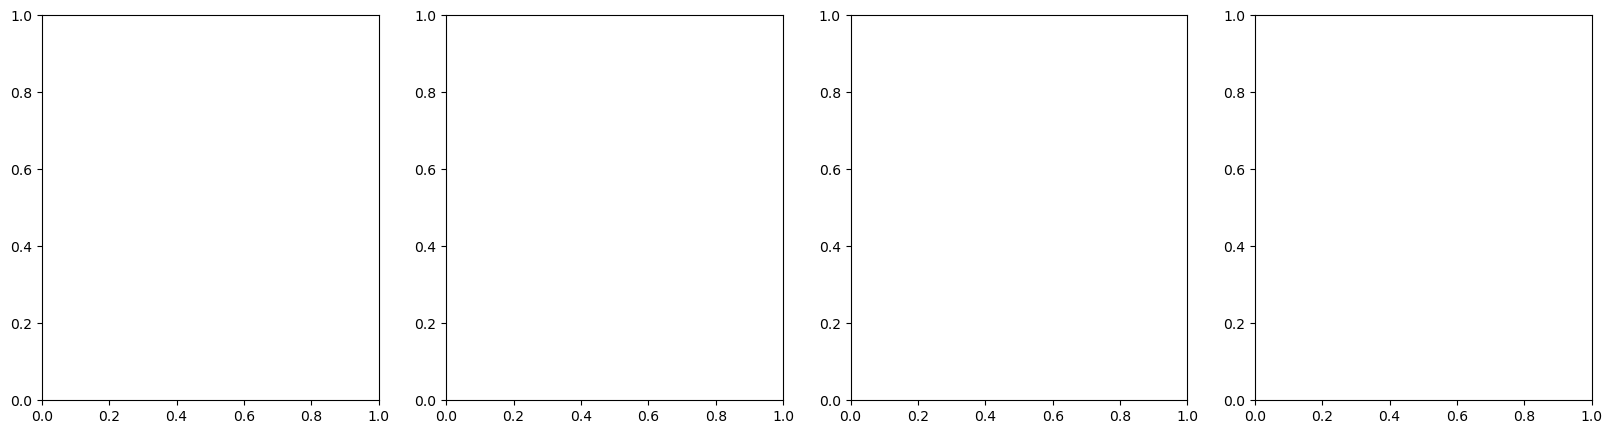

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

# Initialize dataset and dataloader
annotation_file = 'yolo_annotations.json'
image_dir = 'test_7/captured_images_test7'
dataset = YOLODataset(annotation_file, image_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
# Function to visualize a batch of images
def visualize_batch(images, targets):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, target) in enumerate(zip(images, targets)):
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        axes[i].imshow(img)
        boxes = target['boxes'].numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red')
            axes[i].add_patch(rect)
        axes[i].axis('off')
    plt.show()

# Get a batch of data
images, targets = next(iter(dataloader))

# Visualize the batch
visualize_batch(images, targets)

# Loading LatLonModelWith3Digits

In [20]:
lat_lon_model_with_3digits = LatLonModelFFNNWith3Digits()
lat_lon_model_with_3digits.load_state_dict(torch.load('ffnn_location_no_shortened_digits.pt', weights_only=True))  # Load the saved weights
lat_lon_model_with_3digits.eval()  # Set the model to evaluation mode

# Making predictions and saving them
annotation_file = 'yolo_annotations.json'
found_image_dir = "test_7/captured_images_test7"
lat_lon_dataset_with_3digits = YOLODataset(annotation_file, found_image_dir)
lat_lon_test_dataloader = DataLoader(lat_lon_dataset_with_3digits, batch_size=10, shuffle=False)

print(f"Total images in the dataset: {len(lat_lon_dataset_with_3digits)}")
torch.set_printoptions(precision=8)

# corrected_image = open_csv(csv_path)

all_predictions = []
all_targets = []
image_paths = []  # Uncommented to track image paths
with torch.no_grad():
    for inputs, targets in lat_lon_test_dataloader:
        # Predict outputs
        outputs = lat_lon_model_with_3digits(inputs)
        
        # print(outputs)
        all_predictions.append(outputs)
        all_targets.append(targets)
        
        image_paths.append(targets)  
# print(all_predictions)
flat_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()  # Converts to numpy array
flat_image_paths = [path for batch in image_paths for path in batch]  # Flatten image paths if batched

# Check if all images were processed
print(f"Number of batches processed: {len(all_predictions)}")
print(f"Number of predictions made: {sum([len(batch) for batch in all_predictions])}")

data = {
    "image_path" : flat_image_paths,
    "predicted_lat" : flat_predictions[:, 0],
    "predicted_lon": flat_predictions[:, 1]
}

# Creating a csv file for lat and lon with 3 digits 
df = pd.DataFrame(data)
df.to_csv("predictions_for_testing/new_lat_lon_model_with_3digits.csv", index=False, float_format="%.8f")

print(f"Total image paths processed: {len(image_paths)}")

Total images in the dataset: 2112
Number of batches processed: 212
Number of predictions made: 2112
Total image paths processed: 212


# Loading and Predicting FFNNLatLonModel Without 3 digits

In [49]:
lat_lon_model_without_3digits_path = "ffnn_location_shortened_digits(3).pt"

lat_lon_model_without_3digits = LatLonModelFFNNWithOut3Digits()
lat_lon_model_without_3digits.load_state_dict(torch.load(lat_lon_model_without_3digits_path, weights_only=True))  # Load the saved weights
lat_lon_model_without_3digits.eval()  # Set the model to evaluation mode

# Making predictions and saving them
annotation_file = 'yolo_annotations.json'
found_image_dir = "test_7/captured_images_test7"
lat_lon_dataset_without_3digits = YOLODataset(annotation_file, found_image_dir)
lat_lon_test_dataloader = DataLoader(lat_lon_dataset_without_3digits, batch_size=10, shuffle=False)

print(f"Total images in the dataset: {len(lat_lon_dataset_without_3digits)}")
torch.set_printoptions(precision=8)

all_predictions = []
all_targets = []
image_paths = []  # Uncommented to track image paths
with torch.no_grad():
    for inputs, targets in lat_lon_test_dataloader:
        # Predict outputs
        outputs = lat_lon_model_without_3digits(inputs)
        
        all_predictions.append(outputs)
        all_targets.append(targets)
        image_paths.append(targets)

flat_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()  # Converts to numpy array
flat_image_paths = [path for batch in image_paths for path in batch]  # Flatten image paths if batched

# Adjusting lat/lon as per the required formula
adjusted_predictions_lat = []
adjusted_predictions_lon = []


for i in range(len(flat_predictions)):
    predicted_lat, predicted_lon = flat_predictions[i]

    predicted_lat = predicted_lat / 1000.0 + 35.7
    predicted_lon = predicted_lon / -1000.0 - 78.6
    
    adjusted_predictions_lat.append(predicted_lat)
    adjusted_predictions_lon.append(predicted_lon)

# Creating a DataFrame for lat and lon with 3 digits 
data = {
    "image_path": flat_image_paths,
    "predicted_lat": adjusted_predictions_lat,
    "predicted_lon": adjusted_predictions_lon,

}

df = pd.DataFrame(data)
df.to_csv("predictions_for_testing/YOLO_FFNN_lat_lon_without_3digits(1).csv", index=False, float_format="%.8f")

print(f"Total image paths processed: {len(image_paths)}")


Total images in the dataset: 2112
Total image paths processed: 212


# Loading and Predicting LSTMLatLonModel Without 3 digits

In [56]:
lstm_model_without_3digits_path = "lstm_location_shortened_digits(3).pt"

lstm_model_without_3digits = LatLonModelLSTMWithout3digits()
lstm_model_without_3digits.load_state_dict(torch.load(lstm_model_without_3digits_path, weights_only=True))
lstm_model_without_3digits.eval()

# Making predictions and saving them
annotation_file = 'yolo_annotations.json'
found_image_dir = "test_7/captured_images_test7"
lat_lon_dataset_without_3digits = COCODataset(annotation_file, found_image_dir)
lat_lon_test_dataloader = DataLoader(lat_lon_dataset_without_3digits, batch_size=10, shuffle=False)

print(f"Total images in the dataset: {len(lat_lon_dataset_without_3digits)}")
torch.set_printoptions(precision=8)

all_predictions = []
all_targets = []
image_paths = []  # Uncommented to track image paths
with torch.no_grad():
    for inputs, targets in lat_lon_test_dataloader:
        # Predict outputs
        outputs = lstm_model_without_3digits(inputs)
        
        all_predictions.append(outputs)
        all_targets.append(targets)
        image_paths.append(targets)

flat_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()  # Converts to numpy array
flat_image_paths = [path for batch in image_paths for path in batch]  # Flatten image paths if batched

# Adjusting lat/lon as per the required formula
adjusted_predictions_lat = []
adjusted_predictions_lon = []


for i in range(len(flat_predictions)):
    predicted_lat, predicted_lon = flat_predictions[i]

    predicted_lat = predicted_lat / 1000.0 + 35.7
    predicted_lon = predicted_lon / -1000.0 - 78.6
    
    adjusted_predictions_lat.append(predicted_lat)
    adjusted_predictions_lon.append(predicted_lon)

# Creating a DataFrame for lat and lon with 3 digits 
data = {
    "image_path": flat_image_paths,
    "predicted_lat": adjusted_predictions_lat,
    "predicted_lon": adjusted_predictions_lon,

}

df = pd.DataFrame(data)
df.to_csv("predictions_for_testing/YOLO_LSTM_lat_lon_without_3digits.csv", index=False, float_format="%.8f")

print(f"Total image paths processed: {len(image_paths)}")


Total images in the dataset: 2112
Total image paths processed: 212


# Loading and Predicting LSTMLatLonModel With 3 digits

In [57]:
lstm_model_without_3digits_path = "lstm_location_no_shortened_digits.pt"

lstm_model_without_3digits = LatLonModelLSTMWithout3digits()
lstm_model_without_3digits.load_state_dict(torch.load(lstm_model_without_3digits_path, weights_only=True))
lstm_model_without_3digits.eval()

# Making predictions and saving them
annotation_file = 'yolo_annotations.json'
found_image_dir = "test_7/captured_images_test7"
lat_lon_dataset_without_3digits = COCODataset(annotation_file, found_image_dir)
lat_lon_test_dataloader = DataLoader(lat_lon_dataset_without_3digits, batch_size=10, shuffle=False)

print(f"Total images in the dataset: {len(lat_lon_dataset_without_3digits)}")
torch.set_printoptions(precision=8)

all_predictions = []
all_targets = []
image_paths = []  # Uncommented to track image paths
with torch.no_grad():
    for inputs, targets in lat_lon_test_dataloader:
        # Predict outputs
        outputs = lstm_model_without_3digits(inputs)
        
        all_predictions.append(outputs)
        all_targets.append(targets)
        image_paths.append(targets)

flat_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()  # Converts to numpy array
flat_image_paths = [path for batch in image_paths for path in batch]  # Flatten image paths if batched

# Adjusting lat/lon as per the required formula
adjusted_predictions_lat = []
adjusted_predictions_lon = []


for i in range(len(flat_predictions)):
    predicted_lat, predicted_lon = flat_predictions[i]

    predicted_lat = predicted_lat
    predicted_lon = predicted_lon
    
    adjusted_predictions_lat.append(predicted_lat)
    adjusted_predictions_lon.append(predicted_lon)

# Creating a DataFrame for lat and lon with 3 digits 
data = {
    "image_path": flat_image_paths,
    "predicted_lat": adjusted_predictions_lat,
    "predicted_lon": adjusted_predictions_lon,

}

df = pd.DataFrame(data)
df.to_csv("predictions_for_testing/YOLO_LSTM_lat_lon_with_3digits.csv", index=False, float_format="%.8f")

print(f"Total image paths processed: {len(image_paths)}")


Total images in the dataset: 2112
Total image paths processed: 212
